# Simple Policy Optimization
Notebook for trying out the tooling involved in using policy gradient methods to train a model on SpaceInvaders.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import gym
import matplotlib.pyplot as plt
tfd = tfp.distributions
%matplotlib inline

In [2]:
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1
# !pip install gym[box2d]

In [3]:
tf.__version__

'2.1.0'

In [4]:
tf.executing_eagerly()

True

In [5]:
tfp.__version__

'0.9.0'

# Create Car Racing environment 

In [6]:
env_name = 'CarRacing-v0' # 'SpaceInvaders-v0'
env = gym.make(env_name)

In [7]:
env.observation_space

Box(96, 96, 3)

In [8]:
env.observation_space.shape

(96, 96, 3)

In [9]:
env.action_space

Box(3,)

Track generation: 1055..1323 -> 268-tiles track


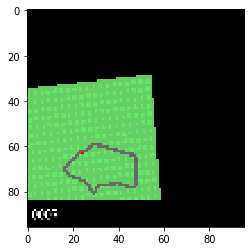

In [10]:
_ = plt.imshow(env.reset())

In [11]:
env.action_space.low, env.action_space.high

(array([-1.,  0.,  0.], dtype=float32), array([1., 1., 1.], dtype=float32))

In [12]:
# Sampling from action space randomly
# tfd.Multinomial(total_count=1, logits=[-1.] * env.action_space.n).sample(1)
env.action_space.sample()

array([-0.54478824,  0.48950446,  0.732836  ], dtype=float32)

# Next step: create h x w x n_frame tensor 
We can implement sequence of frames by allocating an initial h x w x n_frame tensor and for each new frame
rolling the tensor along axis 2 then assigning the new frame to channel 0. Is there a better or more idiomatic way to do this?
Could concatenate each new frame onto buffer.

In [69]:
buffer = tf.zeros((9,) + env.observation_space.shape, dtype=tf.uint8)

In [70]:
buffer.shape

TensorShape([9, 96, 96, 3])

In [71]:
network = tf.keras.models.Sequential()
network.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=buffer.shape[1:]))
network.add(tf.keras.layers.MaxPooling2D((2,2)))
network.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
network.add(tf.keras.layers.MaxPooling2D((2,2)))
network.add(tf.keras.layers.Flatten())
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


In [72]:
# f = plt.figure()
for i in range(100):
    obs, reward, done, info = env.step(env.action_space.sample())
    updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
    buffer = updated_buffer
#     _ = plt.imshow(buffer[0, ...])
#     plt.show()

In [73]:
network.build()

In [74]:
network(buffer.numpy().astype('float32'))

<tf.Tensor: shape=(9, 30976), dtype=float32, numpy=
array([[29.975355, 27.475891,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [29.975355, 27.475891,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [29.975355, 27.475891,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [29.975355, 27.475891,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [29.975355, 27.475891,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [29.975355, 27.475891,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)>

In [75]:
def seq_to_img(seq, n):
    res = []
    for i in range(n):
        res.append(tf.concat([seq[i*n + j, ...] for j in range(n)], axis=1))
    return tf.concat(res, axis=0)

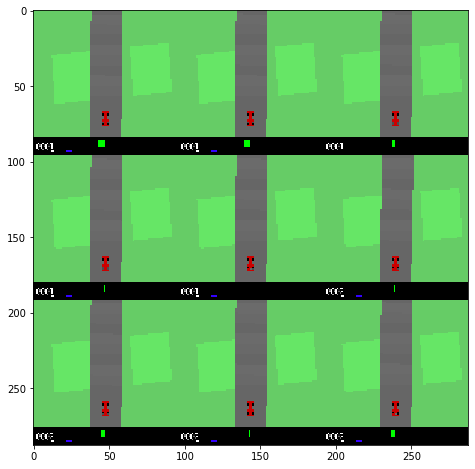

In [76]:
fig = plt.figure(figsize=(12,8))
# _ = plt.imshow(tf.reshape(tf.transpose(buffer, perm=[3, 2, 1, 0]), (2*96, 2*96, -1)))
_ = plt.imshow(seq_to_img(buffer, 3))
ax = plt.gca()
# ax.axis('equal')
ax.set_aspect('equal', 'box')
fig.savefig('test.png')